In [1]:
import torchray
import numpy as np
import xml.etree.ElementTree as ET
import cv2
import time
import torch
from torch.autograd import Variable
from torchvision import models
import sys
import numpy as np
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import glob
import torchray.benchmark
from torchray.attribution.gradient import gradient
from matplotlib import pyplot as plt
import torchray.benchmark.pointing_game
import os
import miscel
from torchray.attribution.grad_cam import grad_cam


In [2]:
use_cuda = torch.cuda.is_available()
def loadAlex():
    model = models.alexnet(pretrained=True)
    model.eval()
    if use_cuda:
        model.cuda()

    for p in model.parameters():
        p.requires_grad = False

    return model

def loadResnet():
    model = models.resnet50(pretrained=True)
    model.eval()
    if use_cuda:
        model.cuda()

    for p in model.parameters():
        p.requires_grad = False

    return model

def loadvgg():
    model = models.vgg16(pretrained=True)
    model.eval()
    if use_cuda:
        model.cuda()

    for p in model.parameters():
        p.requires_grad = False

    return model

In [3]:


val_transforms = transforms.Compose([transforms.Resize(256),transforms.CenterCrop(224), transforms.ToTensor(),
              transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])    

vall = torchray.benchmark.datasets.ImageFolder('/home/mallet/Desktop/VanillaVsARobust/validationSample',
                                            transform = val_transforms)
model = loadvgg()

In [4]:
# Validating energy based pointing game of ScoreCam, using Gradient and VGG16: they reported 41.3%,
# we obtained 41.6%

# Initializing number of hits in pointing game and total time
ttotal = 0
pgtot = 0
pgms=0
# Initializing list for runtime
l = []

# number of images we need to calculate things for
nimg = vall.selection
aaa = 0
for i in range(1000):
    img, labele = vall[i]
    bbname = vall.get_image_url(i).split("/")[-1].split(".")[0]             # Extracting image url to retrieve its BB
    imwidth, imheight, xmin, ymin, xmax, ymax = miscel.bbinfo(bbname)
    aimg = imwidth*imheight
    abb = (xmax-xmin)*(ymax-ymin)

    if aimg>2*abb:

        aaa+=1
        x = img.unsqueeze(0)
        x = x.cuda()
        saliency = gradient(model, x, labele)
        end = time.time()
        #print(saliency)
        saliency = (saliency - torch.min(saliency))/torch.max(saliency)
        #print(saliency)
        salmap = miscel.sares(saliency, imwidth, imheight)
        alenergy = np.sum(salmap)
        Y, a = miscel.gtbb(imwidth, imheight, xmin, ymin, xmax, ymax)
        whlene = np.multiply(a, salmap)
        gdener = np.sum(whlene)
        dd = gdener/alenergy
        if dd ==0:
            print("what the hell happened?")
        l.append(dd)
        
print("wtf: ", sum(l)/aaa)
print(aaa)


wtf:  0.4166934081329192
536


In [8]:
# Validating energy based pointing game of ScoreCam, using GradCam and VGG16. Reported 48%, got 45%.
# It is close enough!

# Initializing number of hits in pointing game and total time
ttotal = 0
pgtot = 0
pgms=0
# Initializing list for runtime
l = []

# number of images we need to calculate things for
nimg = vall.selection
aaa = 0
for i in range(1000):
    img, labele = vall[i]
    bbname = vall.get_image_url(i).split("/")[-1].split(".")[0]             # Extracting image url to retrieve its BB
    imwidth, imheight, xmin, ymin, xmax, ymax = miscel.bbinfo(bbname)
    aimg = imwidth*imheight
    abb = (xmax-xmin)*(ymax-ymin)

    if aimg>2*abb:

        aaa+=1
        x = img.unsqueeze(0)
        x = x.cuda()
        saliency = grad_cam(model, x, labele, saliency_layer='features.29')
        end = time.time()
        #print(saliency)
        saliency = (saliency - torch.min(saliency))/torch.max(saliency)
        #print(saliency)
        salmap = miscel.sares(saliency, imwidth, imheight)
        alenergy = np.sum(salmap)
        Y, a = miscel.gtbb(imwidth, imheight, xmin, ymin, xmax, ymax)
        whlene = np.multiply(a, salmap)
        gdener = np.sum(whlene)
        dd = gdener/alenergy
        if dd ==0:
            print("what the hell happened?")
        l.append(dd)
        
print("wtf: ", sum(l)/aaa)
print(aaa)


wtf:  0.4500439454660756
536


(224, 224)


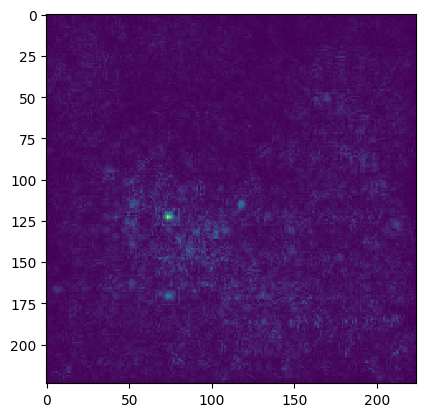

(224, 224)


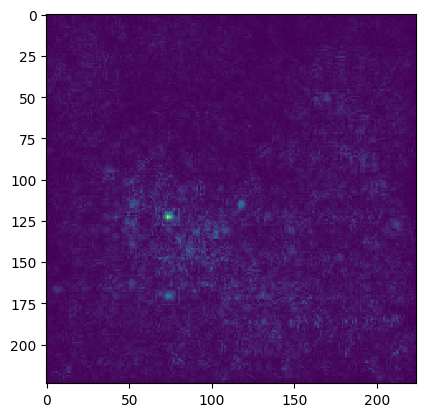

In [51]:
saliency = saliency.cpu().detach().numpy()
print(saliency.shape)
plt.imshow(saliency, interpolation='nearest')
plt.show()
salresized = cv2.resize(saliency, (224,224))
print(salresized.shape)
plt.imshow(salresized, interpolation='nearest')
plt.show()

275 123


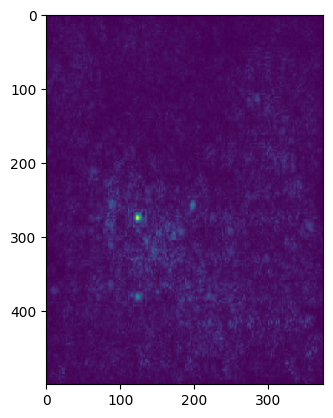

0.0037258514
0.11021502


NameError: name 'imgwidth' is not defined

In [46]:
xloc,yloc = np.unravel_index(salresized.argmax(), salresized.shape)
print(xloc, yloc)      
print(salresized[194,154])
print(np.amax(salresized))
print(imheight, imgwidth)

In [73]:

xmin = int(root[5][4][0].text)
ymin = int(root[5][4][1].text)
xmax = int(root[5][4][2].text)
ymax = int(root[5][4][3].text)
Y = torch.zeros((imheight,imwidth), dtype=torch.bool)
Y[ymin:ymax, xmin:xmax]=True
test = torchray.benchmark.pointing_game.PointingGame(1000, tolerance=15)
pg = test.evaluate(Y, (xloc,yloc))
print(pg)

1


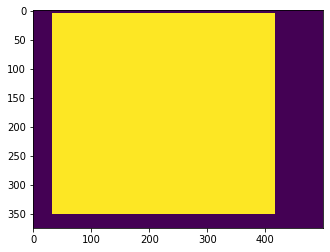

In [74]:
plt.imshow(Y, interpolation='nearest')
plt.show()

torch.Size([400, 600])


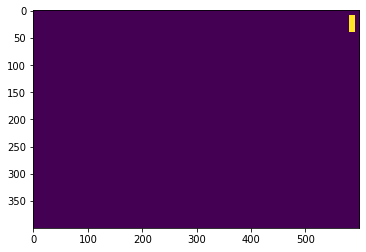

1


In [79]:
X = torch.zeros((400,600), dtype=torch.bool)
print(X.shape)
X[10:40, 580:590]=True
plt.imshow(X, interpolation='nearest')
plt.show()

test = torchray.benchmark.pointing_game.PointingGame(1000, tolerance=15)
pg = test.evaluate(X, (590, 11))
print(pg)

In [151]:
from robustness import imagenet_models
#from sam.naman_robustness import model_utils
#from sam import utils
#model = model_utils.make_and_restore_model(arch=) (arch="madry")
state = torch.load('/home/mallet/Downloads/ResNet50_R.pt')
#model = resnet50()
#print(state["model"])
#model.load_state_dict(state["model"])
mdls = imagenet_models.__dict__['resnet50'](num_classes=1000)
#modelss = imagenet_models.resnet50(pretrained=True)
print(mdls)
model.load_state_dict(state["model"])

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): SequentialWithArgs(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), str

RuntimeError: Error(s) in loading state_dict for ResNet:
	Missing key(s) in state_dict: "conv1.weight", "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "layer1.0.conv1.weight", "layer1.0.bn1.weight", "layer1.0.bn1.bias", "layer1.0.bn1.running_mean", "layer1.0.bn1.running_var", "layer1.0.conv2.weight", "layer1.0.bn2.weight", "layer1.0.bn2.bias", "layer1.0.bn2.running_mean", "layer1.0.bn2.running_var", "layer1.0.conv3.weight", "layer1.0.bn3.weight", "layer1.0.bn3.bias", "layer1.0.bn3.running_mean", "layer1.0.bn3.running_var", "layer1.0.downsample.0.weight", "layer1.0.downsample.1.weight", "layer1.0.downsample.1.bias", "layer1.0.downsample.1.running_mean", "layer1.0.downsample.1.running_var", "layer1.1.conv1.weight", "layer1.1.bn1.weight", "layer1.1.bn1.bias", "layer1.1.bn1.running_mean", "layer1.1.bn1.running_var", "layer1.1.conv2.weight", "layer1.1.bn2.weight", "layer1.1.bn2.bias", "layer1.1.bn2.running_mean", "layer1.1.bn2.running_var", "layer1.1.conv3.weight", "layer1.1.bn3.weight", "layer1.1.bn3.bias", "layer1.1.bn3.running_mean", "layer1.1.bn3.running_var", "layer1.2.conv1.weight", "layer1.2.bn1.weight", "layer1.2.bn1.bias", "layer1.2.bn1.running_mean", "layer1.2.bn1.running_var", "layer1.2.conv2.weight", "layer1.2.bn2.weight", "layer1.2.bn2.bias", "layer1.2.bn2.running_mean", "layer1.2.bn2.running_var", "layer1.2.conv3.weight", "layer1.2.bn3.weight", "layer1.2.bn3.bias", "layer1.2.bn3.running_mean", "layer1.2.bn3.running_var", "layer2.0.conv1.weight", "layer2.0.bn1.weight", "layer2.0.bn1.bias", "layer2.0.bn1.running_mean", "layer2.0.bn1.running_var", "layer2.0.conv2.weight", "layer2.0.bn2.weight", "layer2.0.bn2.bias", "layer2.0.bn2.running_mean", "layer2.0.bn2.running_var", "layer2.0.conv3.weight", "layer2.0.bn3.weight", "layer2.0.bn3.bias", "layer2.0.bn3.running_mean", "layer2.0.bn3.running_var", "layer2.0.downsample.0.weight", "layer2.0.downsample.1.weight", "layer2.0.downsample.1.bias", "layer2.0.downsample.1.running_mean", "layer2.0.downsample.1.running_var", "layer2.1.conv1.weight", "layer2.1.bn1.weight", "layer2.1.bn1.bias", "layer2.1.bn1.running_mean", "layer2.1.bn1.running_var", "layer2.1.conv2.weight", "layer2.1.bn2.weight", "layer2.1.bn2.bias", "layer2.1.bn2.running_mean", "layer2.1.bn2.running_var", "layer2.1.conv3.weight", "layer2.1.bn3.weight", "layer2.1.bn3.bias", "layer2.1.bn3.running_mean", "layer2.1.bn3.running_var", "layer2.2.conv1.weight", "layer2.2.bn1.weight", "layer2.2.bn1.bias", "layer2.2.bn1.running_mean", "layer2.2.bn1.running_var", "layer2.2.conv2.weight", "layer2.2.bn2.weight", "layer2.2.bn2.bias", "layer2.2.bn2.running_mean", "layer2.2.bn2.running_var", "layer2.2.conv3.weight", "layer2.2.bn3.weight", "layer2.2.bn3.bias", "layer2.2.bn3.running_mean", "layer2.2.bn3.running_var", "layer2.3.conv1.weight", "layer2.3.bn1.weight", "layer2.3.bn1.bias", "layer2.3.bn1.running_mean", "layer2.3.bn1.running_var", "layer2.3.conv2.weight", "layer2.3.bn2.weight", "layer2.3.bn2.bias", "layer2.3.bn2.running_mean", "layer2.3.bn2.running_var", "layer2.3.conv3.weight", "layer2.3.bn3.weight", "layer2.3.bn3.bias", "layer2.3.bn3.running_mean", "layer2.3.bn3.running_var", "layer3.0.conv1.weight", "layer3.0.bn1.weight", "layer3.0.bn1.bias", "layer3.0.bn1.running_mean", "layer3.0.bn1.running_var", "layer3.0.conv2.weight", "layer3.0.bn2.weight", "layer3.0.bn2.bias", "layer3.0.bn2.running_mean", "layer3.0.bn2.running_var", "layer3.0.conv3.weight", "layer3.0.bn3.weight", "layer3.0.bn3.bias", "layer3.0.bn3.running_mean", "layer3.0.bn3.running_var", "layer3.0.downsample.0.weight", "layer3.0.downsample.1.weight", "layer3.0.downsample.1.bias", "layer3.0.downsample.1.running_mean", "layer3.0.downsample.1.running_var", "layer3.1.conv1.weight", "layer3.1.bn1.weight", "layer3.1.bn1.bias", "layer3.1.bn1.running_mean", "layer3.1.bn1.running_var", "layer3.1.conv2.weight", "layer3.1.bn2.weight", "layer3.1.bn2.bias", "layer3.1.bn2.running_mean", "layer3.1.bn2.running_var", "layer3.1.conv3.weight", "layer3.1.bn3.weight", "layer3.1.bn3.bias", "layer3.1.bn3.running_mean", "layer3.1.bn3.running_var", "layer3.2.conv1.weight", "layer3.2.bn1.weight", "layer3.2.bn1.bias", "layer3.2.bn1.running_mean", "layer3.2.bn1.running_var", "layer3.2.conv2.weight", "layer3.2.bn2.weight", "layer3.2.bn2.bias", "layer3.2.bn2.running_mean", "layer3.2.bn2.running_var", "layer3.2.conv3.weight", "layer3.2.bn3.weight", "layer3.2.bn3.bias", "layer3.2.bn3.running_mean", "layer3.2.bn3.running_var", "layer3.3.conv1.weight", "layer3.3.bn1.weight", "layer3.3.bn1.bias", "layer3.3.bn1.running_mean", "layer3.3.bn1.running_var", "layer3.3.conv2.weight", "layer3.3.bn2.weight", "layer3.3.bn2.bias", "layer3.3.bn2.running_mean", "layer3.3.bn2.running_var", "layer3.3.conv3.weight", "layer3.3.bn3.weight", "layer3.3.bn3.bias", "layer3.3.bn3.running_mean", "layer3.3.bn3.running_var", "layer3.4.conv1.weight", "layer3.4.bn1.weight", "layer3.4.bn1.bias", "layer3.4.bn1.running_mean", "layer3.4.bn1.running_var", "layer3.4.conv2.weight", "layer3.4.bn2.weight", "layer3.4.bn2.bias", "layer3.4.bn2.running_mean", "layer3.4.bn2.running_var", "layer3.4.conv3.weight", "layer3.4.bn3.weight", "layer3.4.bn3.bias", "layer3.4.bn3.running_mean", "layer3.4.bn3.running_var", "layer3.5.conv1.weight", "layer3.5.bn1.weight", "layer3.5.bn1.bias", "layer3.5.bn1.running_mean", "layer3.5.bn1.running_var", "layer3.5.conv2.weight", "layer3.5.bn2.weight", "layer3.5.bn2.bias", "layer3.5.bn2.running_mean", "layer3.5.bn2.running_var", "layer3.5.conv3.weight", "layer3.5.bn3.weight", "layer3.5.bn3.bias", "layer3.5.bn3.running_mean", "layer3.5.bn3.running_var", "layer4.0.conv1.weight", "layer4.0.bn1.weight", "layer4.0.bn1.bias", "layer4.0.bn1.running_mean", "layer4.0.bn1.running_var", "layer4.0.conv2.weight", "layer4.0.bn2.weight", "layer4.0.bn2.bias", "layer4.0.bn2.running_mean", "layer4.0.bn2.running_var", "layer4.0.conv3.weight", "layer4.0.bn3.weight", "layer4.0.bn3.bias", "layer4.0.bn3.running_mean", "layer4.0.bn3.running_var", "layer4.0.downsample.0.weight", "layer4.0.downsample.1.weight", "layer4.0.downsample.1.bias", "layer4.0.downsample.1.running_mean", "layer4.0.downsample.1.running_var", "layer4.1.conv1.weight", "layer4.1.bn1.weight", "layer4.1.bn1.bias", "layer4.1.bn1.running_mean", "layer4.1.bn1.running_var", "layer4.1.conv2.weight", "layer4.1.bn2.weight", "layer4.1.bn2.bias", "layer4.1.bn2.running_mean", "layer4.1.bn2.running_var", "layer4.1.conv3.weight", "layer4.1.bn3.weight", "layer4.1.bn3.bias", "layer4.1.bn3.running_mean", "layer4.1.bn3.running_var", "layer4.2.conv1.weight", "layer4.2.bn1.weight", "layer4.2.bn1.bias", "layer4.2.bn1.running_mean", "layer4.2.bn1.running_var", "layer4.2.conv2.weight", "layer4.2.bn2.weight", "layer4.2.bn2.bias", "layer4.2.bn2.running_mean", "layer4.2.bn2.running_var", "layer4.2.conv3.weight", "layer4.2.bn3.weight", "layer4.2.bn3.bias", "layer4.2.bn3.running_mean", "layer4.2.bn3.running_var", "fc.weight", "fc.bias". 
	Unexpected key(s) in state_dict: "module.normalizer.new_mean", "module.normalizer.new_std", "module.model.conv1.weight", "module.model.bn1.weight", "module.model.bn1.bias", "module.model.bn1.running_mean", "module.model.bn1.running_var", "module.model.bn1.num_batches_tracked", "module.model.layer1.0.conv1.weight", "module.model.layer1.0.bn1.weight", "module.model.layer1.0.bn1.bias", "module.model.layer1.0.bn1.running_mean", "module.model.layer1.0.bn1.running_var", "module.model.layer1.0.bn1.num_batches_tracked", "module.model.layer1.0.conv2.weight", "module.model.layer1.0.bn2.weight", "module.model.layer1.0.bn2.bias", "module.model.layer1.0.bn2.running_mean", "module.model.layer1.0.bn2.running_var", "module.model.layer1.0.bn2.num_batches_tracked", "module.model.layer1.0.conv3.weight", "module.model.layer1.0.bn3.weight", "module.model.layer1.0.bn3.bias", "module.model.layer1.0.bn3.running_mean", "module.model.layer1.0.bn3.running_var", "module.model.layer1.0.bn3.num_batches_tracked", "module.model.layer1.0.downsample.0.weight", "module.model.layer1.0.downsample.1.weight", "module.model.layer1.0.downsample.1.bias", "module.model.layer1.0.downsample.1.running_mean", "module.model.layer1.0.downsample.1.running_var", "module.model.layer1.0.downsample.1.num_batches_tracked", "module.model.layer1.1.conv1.weight", "module.model.layer1.1.bn1.weight", "module.model.layer1.1.bn1.bias", "module.model.layer1.1.bn1.running_mean", "module.model.layer1.1.bn1.running_var", "module.model.layer1.1.bn1.num_batches_tracked", "module.model.layer1.1.conv2.weight", "module.model.layer1.1.bn2.weight", "module.model.layer1.1.bn2.bias", "module.model.layer1.1.bn2.running_mean", "module.model.layer1.1.bn2.running_var", "module.model.layer1.1.bn2.num_batches_tracked", "module.model.layer1.1.conv3.weight", "module.model.layer1.1.bn3.weight", "module.model.layer1.1.bn3.bias", "module.model.layer1.1.bn3.running_mean", "module.model.layer1.1.bn3.running_var", "module.model.layer1.1.bn3.num_batches_tracked", "module.model.layer1.2.conv1.weight", "module.model.layer1.2.bn1.weight", "module.model.layer1.2.bn1.bias", "module.model.layer1.2.bn1.running_mean", "module.model.layer1.2.bn1.running_var", "module.model.layer1.2.bn1.num_batches_tracked", "module.model.layer1.2.conv2.weight", "module.model.layer1.2.bn2.weight", "module.model.layer1.2.bn2.bias", "module.model.layer1.2.bn2.running_mean", "module.model.layer1.2.bn2.running_var", "module.model.layer1.2.bn2.num_batches_tracked", "module.model.layer1.2.conv3.weight", "module.model.layer1.2.bn3.weight", "module.model.layer1.2.bn3.bias", "module.model.layer1.2.bn3.running_mean", "module.model.layer1.2.bn3.running_var", "module.model.layer1.2.bn3.num_batches_tracked", "module.model.layer2.0.conv1.weight", "module.model.layer2.0.bn1.weight", "module.model.layer2.0.bn1.bias", "module.model.layer2.0.bn1.running_mean", "module.model.layer2.0.bn1.running_var", "module.model.layer2.0.bn1.num_batches_tracked", "module.model.layer2.0.conv2.weight", "module.model.layer2.0.bn2.weight", "module.model.layer2.0.bn2.bias", "module.model.layer2.0.bn2.running_mean", "module.model.layer2.0.bn2.running_var", "module.model.layer2.0.bn2.num_batches_tracked", "module.model.layer2.0.conv3.weight", "module.model.layer2.0.bn3.weight", "module.model.layer2.0.bn3.bias", "module.model.layer2.0.bn3.running_mean", "module.model.layer2.0.bn3.running_var", "module.model.layer2.0.bn3.num_batches_tracked", "module.model.layer2.0.downsample.0.weight", "module.model.layer2.0.downsample.1.weight", "module.model.layer2.0.downsample.1.bias", "module.model.layer2.0.downsample.1.running_mean", "module.model.layer2.0.downsample.1.running_var", "module.model.layer2.0.downsample.1.num_batches_tracked", "module.model.layer2.1.conv1.weight", "module.model.layer2.1.bn1.weight", "module.model.layer2.1.bn1.bias", "module.model.layer2.1.bn1.running_mean", "module.model.layer2.1.bn1.running_var", "module.model.layer2.1.bn1.num_batches_tracked", "module.model.layer2.1.conv2.weight", "module.model.layer2.1.bn2.weight", "module.model.layer2.1.bn2.bias", "module.model.layer2.1.bn2.running_mean", "module.model.layer2.1.bn2.running_var", "module.model.layer2.1.bn2.num_batches_tracked", "module.model.layer2.1.conv3.weight", "module.model.layer2.1.bn3.weight", "module.model.layer2.1.bn3.bias", "module.model.layer2.1.bn3.running_mean", "module.model.layer2.1.bn3.running_var", "module.model.layer2.1.bn3.num_batches_tracked", "module.model.layer2.2.conv1.weight", "module.model.layer2.2.bn1.weight", "module.model.layer2.2.bn1.bias", "module.model.layer2.2.bn1.running_mean", "module.model.layer2.2.bn1.running_var", "module.model.layer2.2.bn1.num_batches_tracked", "module.model.layer2.2.conv2.weight", "module.model.layer2.2.bn2.weight", "module.model.layer2.2.bn2.bias", "module.model.layer2.2.bn2.running_mean", "module.model.layer2.2.bn2.running_var", "module.model.layer2.2.bn2.num_batches_tracked", "module.model.layer2.2.conv3.weight", "module.model.layer2.2.bn3.weight", "module.model.layer2.2.bn3.bias", "module.model.layer2.2.bn3.running_mean", "module.model.layer2.2.bn3.running_var", "module.model.layer2.2.bn3.num_batches_tracked", "module.model.layer2.3.conv1.weight", "module.model.layer2.3.bn1.weight", "module.model.layer2.3.bn1.bias", "module.model.layer2.3.bn1.running_mean", "module.model.layer2.3.bn1.running_var", "module.model.layer2.3.bn1.num_batches_tracked", "module.model.layer2.3.conv2.weight", "module.model.layer2.3.bn2.weight", "module.model.layer2.3.bn2.bias", "module.model.layer2.3.bn2.running_mean", "module.model.layer2.3.bn2.running_var", "module.model.layer2.3.bn2.num_batches_tracked", "module.model.layer2.3.conv3.weight", "module.model.layer2.3.bn3.weight", "module.model.layer2.3.bn3.bias", "module.model.layer2.3.bn3.running_mean", "module.model.layer2.3.bn3.running_var", "module.model.layer2.3.bn3.num_batches_tracked", "module.model.layer3.0.conv1.weight", "module.model.layer3.0.bn1.weight", "module.model.layer3.0.bn1.bias", "module.model.layer3.0.bn1.running_mean", "module.model.layer3.0.bn1.running_var", "module.model.layer3.0.bn1.num_batches_tracked", "module.model.layer3.0.conv2.weight", "module.model.layer3.0.bn2.weight", "module.model.layer3.0.bn2.bias", "module.model.layer3.0.bn2.running_mean", "module.model.layer3.0.bn2.running_var", "module.model.layer3.0.bn2.num_batches_tracked", "module.model.layer3.0.conv3.weight", "module.model.layer3.0.bn3.weight", "module.model.layer3.0.bn3.bias", "module.model.layer3.0.bn3.running_mean", "module.model.layer3.0.bn3.running_var", "module.model.layer3.0.bn3.num_batches_tracked", "module.model.layer3.0.downsample.0.weight", "module.model.layer3.0.downsample.1.weight", "module.model.layer3.0.downsample.1.bias", "module.model.layer3.0.downsample.1.running_mean", "module.model.layer3.0.downsample.1.running_var", "module.model.layer3.0.downsample.1.num_batches_tracked", "module.model.layer3.1.conv1.weight", "module.model.layer3.1.bn1.weight", "module.model.layer3.1.bn1.bias", "module.model.layer3.1.bn1.running_mean", "module.model.layer3.1.bn1.running_var", "module.model.layer3.1.bn1.num_batches_tracked", "module.model.layer3.1.conv2.weight", "module.model.layer3.1.bn2.weight", "module.model.layer3.1.bn2.bias", "module.model.layer3.1.bn2.running_mean", "module.model.layer3.1.bn2.running_var", "module.model.layer3.1.bn2.num_batches_tracked", "module.model.layer3.1.conv3.weight", "module.model.layer3.1.bn3.weight", "module.model.layer3.1.bn3.bias", "module.model.layer3.1.bn3.running_mean", "module.model.layer3.1.bn3.running_var", "module.model.layer3.1.bn3.num_batches_tracked", "module.model.layer3.2.conv1.weight", "module.model.layer3.2.bn1.weight", "module.model.layer3.2.bn1.bias", "module.model.layer3.2.bn1.running_mean", "module.model.layer3.2.bn1.running_var", "module.model.layer3.2.bn1.num_batches_tracked", "module.model.layer3.2.conv2.weight", "module.model.layer3.2.bn2.weight", "module.model.layer3.2.bn2.bias", "module.model.layer3.2.bn2.running_mean", "module.model.layer3.2.bn2.running_var", "module.model.layer3.2.bn2.num_batches_tracked", "module.model.layer3.2.conv3.weight", "module.model.layer3.2.bn3.weight", "module.model.layer3.2.bn3.bias", "module.model.layer3.2.bn3.running_mean", "module.model.layer3.2.bn3.running_var", "module.model.layer3.2.bn3.num_batches_tracked", "module.model.layer3.3.conv1.weight", "module.model.layer3.3.bn1.weight", "module.model.layer3.3.bn1.bias", "module.model.layer3.3.bn1.running_mean", "module.model.layer3.3.bn1.running_var", "module.model.layer3.3.bn1.num_batches_tracked", "module.model.layer3.3.conv2.weight", "module.model.layer3.3.bn2.weight", "module.model.layer3.3.bn2.bias", "module.model.layer3.3.bn2.running_mean", "module.model.layer3.3.bn2.running_var", "module.model.layer3.3.bn2.num_batches_tracked", "module.model.layer3.3.conv3.weight", "module.model.layer3.3.bn3.weight", "module.model.layer3.3.bn3.bias", "module.model.layer3.3.bn3.running_mean", "module.model.layer3.3.bn3.running_var", "module.model.layer3.3.bn3.num_batches_tracked", "module.model.layer3.4.conv1.weight", "module.model.layer3.4.bn1.weight", "module.model.layer3.4.bn1.bias", "module.model.layer3.4.bn1.running_mean", "module.model.layer3.4.bn1.running_var", "module.model.layer3.4.bn1.num_batches_tracked", "module.model.layer3.4.conv2.weight", "module.model.layer3.4.bn2.weight", "module.model.layer3.4.bn2.bias", "module.model.layer3.4.bn2.running_mean", "module.model.layer3.4.bn2.running_var", "module.model.layer3.4.bn2.num_batches_tracked", "module.model.layer3.4.conv3.weight", "module.model.layer3.4.bn3.weight", "module.model.layer3.4.bn3.bias", "module.model.layer3.4.bn3.running_mean", "module.model.layer3.4.bn3.running_var", "module.model.layer3.4.bn3.num_batches_tracked", "module.model.layer3.5.conv1.weight", "module.model.layer3.5.bn1.weight", "module.model.layer3.5.bn1.bias", "module.model.layer3.5.bn1.running_mean", "module.model.layer3.5.bn1.running_var", "module.model.layer3.5.bn1.num_batches_tracked", "module.model.layer3.5.conv2.weight", "module.model.layer3.5.bn2.weight", "module.model.layer3.5.bn2.bias", "module.model.layer3.5.bn2.running_mean", "module.model.layer3.5.bn2.running_var", "module.model.layer3.5.bn2.num_batches_tracked", "module.model.layer3.5.conv3.weight", "module.model.layer3.5.bn3.weight", "module.model.layer3.5.bn3.bias", "module.model.layer3.5.bn3.running_mean", "module.model.layer3.5.bn3.running_var", "module.model.layer3.5.bn3.num_batches_tracked", "module.model.layer4.0.conv1.weight", "module.model.layer4.0.bn1.weight", "module.model.layer4.0.bn1.bias", "module.model.layer4.0.bn1.running_mean", "module.model.layer4.0.bn1.running_var", "module.model.layer4.0.bn1.num_batches_tracked", "module.model.layer4.0.conv2.weight", "module.model.layer4.0.bn2.weight", "module.model.layer4.0.bn2.bias", "module.model.layer4.0.bn2.running_mean", "module.model.layer4.0.bn2.running_var", "module.model.layer4.0.bn2.num_batches_tracked", "module.model.layer4.0.conv3.weight", "module.model.layer4.0.bn3.weight", "module.model.layer4.0.bn3.bias", "module.model.layer4.0.bn3.running_mean", "module.model.layer4.0.bn3.running_var", "module.model.layer4.0.bn3.num_batches_tracked", "module.model.layer4.0.downsample.0.weight", "module.model.layer4.0.downsample.1.weight", "module.model.layer4.0.downsample.1.bias", "module.model.layer4.0.downsample.1.running_mean", "module.model.layer4.0.downsample.1.running_var", "module.model.layer4.0.downsample.1.num_batches_tracked", "module.model.layer4.1.conv1.weight", "module.model.layer4.1.bn1.weight", "module.model.layer4.1.bn1.bias", "module.model.layer4.1.bn1.running_mean", "module.model.layer4.1.bn1.running_var", "module.model.layer4.1.bn1.num_batches_tracked", "module.model.layer4.1.conv2.weight", "module.model.layer4.1.bn2.weight", "module.model.layer4.1.bn2.bias", "module.model.layer4.1.bn2.running_mean", "module.model.layer4.1.bn2.running_var", "module.model.layer4.1.bn2.num_batches_tracked", "module.model.layer4.1.conv3.weight", "module.model.layer4.1.bn3.weight", "module.model.layer4.1.bn3.bias", "module.model.layer4.1.bn3.running_mean", "module.model.layer4.1.bn3.running_var", "module.model.layer4.1.bn3.num_batches_tracked", "module.model.layer4.2.conv1.weight", "module.model.layer4.2.bn1.weight", "module.model.layer4.2.bn1.bias", "module.model.layer4.2.bn1.running_mean", "module.model.layer4.2.bn1.running_var", "module.model.layer4.2.bn1.num_batches_tracked", "module.model.layer4.2.conv2.weight", "module.model.layer4.2.bn2.weight", "module.model.layer4.2.bn2.bias", "module.model.layer4.2.bn2.running_mean", "module.model.layer4.2.bn2.running_var", "module.model.layer4.2.bn2.num_batches_tracked", "module.model.layer4.2.conv3.weight", "module.model.layer4.2.bn3.weight", "module.model.layer4.2.bn3.bias", "module.model.layer4.2.bn3.running_mean", "module.model.layer4.2.bn3.running_var", "module.model.layer4.2.bn3.num_batches_tracked", "module.model.fc.weight", "module.model.fc.bias", "module.attacker.normalize.new_mean", "module.attacker.normalize.new_std", "module.attacker.model.conv1.weight", "module.attacker.model.bn1.weight", "module.attacker.model.bn1.bias", "module.attacker.model.bn1.running_mean", "module.attacker.model.bn1.running_var", "module.attacker.model.bn1.num_batches_tracked", "module.attacker.model.layer1.0.conv1.weight", "module.attacker.model.layer1.0.bn1.weight", "module.attacker.model.layer1.0.bn1.bias", "module.attacker.model.layer1.0.bn1.running_mean", "module.attacker.model.layer1.0.bn1.running_var", "module.attacker.model.layer1.0.bn1.num_batches_tracked", "module.attacker.model.layer1.0.conv2.weight", "module.attacker.model.layer1.0.bn2.weight", "module.attacker.model.layer1.0.bn2.bias", "module.attacker.model.layer1.0.bn2.running_mean", "module.attacker.model.layer1.0.bn2.running_var", "module.attacker.model.layer1.0.bn2.num_batches_tracked", "module.attacker.model.layer1.0.conv3.weight", "module.attacker.model.layer1.0.bn3.weight", "module.attacker.model.layer1.0.bn3.bias", "module.attacker.model.layer1.0.bn3.running_mean", "module.attacker.model.layer1.0.bn3.running_var", "module.attacker.model.layer1.0.bn3.num_batches_tracked", "module.attacker.model.layer1.0.downsample.0.weight", "module.attacker.model.layer1.0.downsample.1.weight", "module.attacker.model.layer1.0.downsample.1.bias", "module.attacker.model.layer1.0.downsample.1.running_mean", "module.attacker.model.layer1.0.downsample.1.running_var", "module.attacker.model.layer1.0.downsample.1.num_batches_tracked", "module.attacker.model.layer1.1.conv1.weight", "module.attacker.model.layer1.1.bn1.weight", "module.attacker.model.layer1.1.bn1.bias", "module.attacker.model.layer1.1.bn1.running_mean", "module.attacker.model.layer1.1.bn1.running_var", "module.attacker.model.layer1.1.bn1.num_batches_tracked", "module.attacker.model.layer1.1.conv2.weight", "module.attacker.model.layer1.1.bn2.weight", "module.attacker.model.layer1.1.bn2.bias", "module.attacker.model.layer1.1.bn2.running_mean", "module.attacker.model.layer1.1.bn2.running_var", "module.attacker.model.layer1.1.bn2.num_batches_tracked", "module.attacker.model.layer1.1.conv3.weight", "module.attacker.model.layer1.1.bn3.weight", "module.attacker.model.layer1.1.bn3.bias", "module.attacker.model.layer1.1.bn3.running_mean", "module.attacker.model.layer1.1.bn3.running_var", "module.attacker.model.layer1.1.bn3.num_batches_tracked", "module.attacker.model.layer1.2.conv1.weight", "module.attacker.model.layer1.2.bn1.weight", "module.attacker.model.layer1.2.bn1.bias", "module.attacker.model.layer1.2.bn1.running_mean", "module.attacker.model.layer1.2.bn1.running_var", "module.attacker.model.layer1.2.bn1.num_batches_tracked", "module.attacker.model.layer1.2.conv2.weight", "module.attacker.model.layer1.2.bn2.weight", "module.attacker.model.layer1.2.bn2.bias", "module.attacker.model.layer1.2.bn2.running_mean", "module.attacker.model.layer1.2.bn2.running_var", "module.attacker.model.layer1.2.bn2.num_batches_tracked", "module.attacker.model.layer1.2.conv3.weight", "module.attacker.model.layer1.2.bn3.weight", "module.attacker.model.layer1.2.bn3.bias", "module.attacker.model.layer1.2.bn3.running_mean", "module.attacker.model.layer1.2.bn3.running_var", "module.attacker.model.layer1.2.bn3.num_batches_tracked", "module.attacker.model.layer2.0.conv1.weight", "module.attacker.model.layer2.0.bn1.weight", "module.attacker.model.layer2.0.bn1.bias", "module.attacker.model.layer2.0.bn1.running_mean", "module.attacker.model.layer2.0.bn1.running_var", "module.attacker.model.layer2.0.bn1.num_batches_tracked", "module.attacker.model.layer2.0.conv2.weight", "module.attacker.model.layer2.0.bn2.weight", "module.attacker.model.layer2.0.bn2.bias", "module.attacker.model.layer2.0.bn2.running_mean", "module.attacker.model.layer2.0.bn2.running_var", "module.attacker.model.layer2.0.bn2.num_batches_tracked", "module.attacker.model.layer2.0.conv3.weight", "module.attacker.model.layer2.0.bn3.weight", "module.attacker.model.layer2.0.bn3.bias", "module.attacker.model.layer2.0.bn3.running_mean", "module.attacker.model.layer2.0.bn3.running_var", "module.attacker.model.layer2.0.bn3.num_batches_tracked", "module.attacker.model.layer2.0.downsample.0.weight", "module.attacker.model.layer2.0.downsample.1.weight", "module.attacker.model.layer2.0.downsample.1.bias", "module.attacker.model.layer2.0.downsample.1.running_mean", "module.attacker.model.layer2.0.downsample.1.running_var", "module.attacker.model.layer2.0.downsample.1.num_batches_tracked", "module.attacker.model.layer2.1.conv1.weight", "module.attacker.model.layer2.1.bn1.weight", "module.attacker.model.layer2.1.bn1.bias", "module.attacker.model.layer2.1.bn1.running_mean", "module.attacker.model.layer2.1.bn1.running_var", "module.attacker.model.layer2.1.bn1.num_batches_tracked", "module.attacker.model.layer2.1.conv2.weight", "module.attacker.model.layer2.1.bn2.weight", "module.attacker.model.layer2.1.bn2.bias", "module.attacker.model.layer2.1.bn2.running_mean", "module.attacker.model.layer2.1.bn2.running_var", "module.attacker.model.layer2.1.bn2.num_batches_tracked", "module.attacker.model.layer2.1.conv3.weight", "module.attacker.model.layer2.1.bn3.weight", "module.attacker.model.layer2.1.bn3.bias", "module.attacker.model.layer2.1.bn3.running_mean", "module.attacker.model.layer2.1.bn3.running_var", "module.attacker.model.layer2.1.bn3.num_batches_tracked", "module.attacker.model.layer2.2.conv1.weight", "module.attacker.model.layer2.2.bn1.weight", "module.attacker.model.layer2.2.bn1.bias", "module.attacker.model.layer2.2.bn1.running_mean", "module.attacker.model.layer2.2.bn1.running_var", "module.attacker.model.layer2.2.bn1.num_batches_tracked", "module.attacker.model.layer2.2.conv2.weight", "module.attacker.model.layer2.2.bn2.weight", "module.attacker.model.layer2.2.bn2.bias", "module.attacker.model.layer2.2.bn2.running_mean", "module.attacker.model.layer2.2.bn2.running_var", "module.attacker.model.layer2.2.bn2.num_batches_tracked", "module.attacker.model.layer2.2.conv3.weight", "module.attacker.model.layer2.2.bn3.weight", "module.attacker.model.layer2.2.bn3.bias", "module.attacker.model.layer2.2.bn3.running_mean", "module.attacker.model.layer2.2.bn3.running_var", "module.attacker.model.layer2.2.bn3.num_batches_tracked", "module.attacker.model.layer2.3.conv1.weight", "module.attacker.model.layer2.3.bn1.weight", "module.attacker.model.layer2.3.bn1.bias", "module.attacker.model.layer2.3.bn1.running_mean", "module.attacker.model.layer2.3.bn1.running_var", "module.attacker.model.layer2.3.bn1.num_batches_tracked", "module.attacker.model.layer2.3.conv2.weight", "module.attacker.model.layer2.3.bn2.weight", "module.attacker.model.layer2.3.bn2.bias", "module.attacker.model.layer2.3.bn2.running_mean", "module.attacker.model.layer2.3.bn2.running_var", "module.attacker.model.layer2.3.bn2.num_batches_tracked", "module.attacker.model.layer2.3.conv3.weight", "module.attacker.model.layer2.3.bn3.weight", "module.attacker.model.layer2.3.bn3.bias", "module.attacker.model.layer2.3.bn3.running_mean", "module.attacker.model.layer2.3.bn3.running_var", "module.attacker.model.layer2.3.bn3.num_batches_tracked", "module.attacker.model.layer3.0.conv1.weight", "module.attacker.model.layer3.0.bn1.weight", "module.attacker.model.layer3.0.bn1.bias", "module.attacker.model.layer3.0.bn1.running_mean", "module.attacker.model.layer3.0.bn1.running_var", "module.attacker.model.layer3.0.bn1.num_batches_tracked", "module.attacker.model.layer3.0.conv2.weight", "module.attacker.model.layer3.0.bn2.weight", "module.attacker.model.layer3.0.bn2.bias", "module.attacker.model.layer3.0.bn2.running_mean", "module.attacker.model.layer3.0.bn2.running_var", "module.attacker.model.layer3.0.bn2.num_batches_tracked", "module.attacker.model.layer3.0.conv3.weight", "module.attacker.model.layer3.0.bn3.weight", "module.attacker.model.layer3.0.bn3.bias", "module.attacker.model.layer3.0.bn3.running_mean", "module.attacker.model.layer3.0.bn3.running_var", "module.attacker.model.layer3.0.bn3.num_batches_tracked", "module.attacker.model.layer3.0.downsample.0.weight", "module.attacker.model.layer3.0.downsample.1.weight", "module.attacker.model.layer3.0.downsample.1.bias", "module.attacker.model.layer3.0.downsample.1.running_mean", "module.attacker.model.layer3.0.downsample.1.running_var", "module.attacker.model.layer3.0.downsample.1.num_batches_tracked", "module.attacker.model.layer3.1.conv1.weight", "module.attacker.model.layer3.1.bn1.weight", "module.attacker.model.layer3.1.bn1.bias", "module.attacker.model.layer3.1.bn1.running_mean", "module.attacker.model.layer3.1.bn1.running_var", "module.attacker.model.layer3.1.bn1.num_batches_tracked", "module.attacker.model.layer3.1.conv2.weight", "module.attacker.model.layer3.1.bn2.weight", "module.attacker.model.layer3.1.bn2.bias", "module.attacker.model.layer3.1.bn2.running_mean", "module.attacker.model.layer3.1.bn2.running_var", "module.attacker.model.layer3.1.bn2.num_batches_tracked", "module.attacker.model.layer3.1.conv3.weight", "module.attacker.model.layer3.1.bn3.weight", "module.attacker.model.layer3.1.bn3.bias", "module.attacker.model.layer3.1.bn3.running_mean", "module.attacker.model.layer3.1.bn3.running_var", "module.attacker.model.layer3.1.bn3.num_batches_tracked", "module.attacker.model.layer3.2.conv1.weight", "module.attacker.model.layer3.2.bn1.weight", "module.attacker.model.layer3.2.bn1.bias", "module.attacker.model.layer3.2.bn1.running_mean", "module.attacker.model.layer3.2.bn1.running_var", "module.attacker.model.layer3.2.bn1.num_batches_tracked", "module.attacker.model.layer3.2.conv2.weight", "module.attacker.model.layer3.2.bn2.weight", "module.attacker.model.layer3.2.bn2.bias", "module.attacker.model.layer3.2.bn2.running_mean", "module.attacker.model.layer3.2.bn2.running_var", "module.attacker.model.layer3.2.bn2.num_batches_tracked", "module.attacker.model.layer3.2.conv3.weight", "module.attacker.model.layer3.2.bn3.weight", "module.attacker.model.layer3.2.bn3.bias", "module.attacker.model.layer3.2.bn3.running_mean", "module.attacker.model.layer3.2.bn3.running_var", "module.attacker.model.layer3.2.bn3.num_batches_tracked", "module.attacker.model.layer3.3.conv1.weight", "module.attacker.model.layer3.3.bn1.weight", "module.attacker.model.layer3.3.bn1.bias", "module.attacker.model.layer3.3.bn1.running_mean", "module.attacker.model.layer3.3.bn1.running_var", "module.attacker.model.layer3.3.bn1.num_batches_tracked", "module.attacker.model.layer3.3.conv2.weight", "module.attacker.model.layer3.3.bn2.weight", "module.attacker.model.layer3.3.bn2.bias", "module.attacker.model.layer3.3.bn2.running_mean", "module.attacker.model.layer3.3.bn2.running_var", "module.attacker.model.layer3.3.bn2.num_batches_tracked", "module.attacker.model.layer3.3.conv3.weight", "module.attacker.model.layer3.3.bn3.weight", "module.attacker.model.layer3.3.bn3.bias", "module.attacker.model.layer3.3.bn3.running_mean", "module.attacker.model.layer3.3.bn3.running_var", "module.attacker.model.layer3.3.bn3.num_batches_tracked", "module.attacker.model.layer3.4.conv1.weight", "module.attacker.model.layer3.4.bn1.weight", "module.attacker.model.layer3.4.bn1.bias", "module.attacker.model.layer3.4.bn1.running_mean", "module.attacker.model.layer3.4.bn1.running_var", "module.attacker.model.layer3.4.bn1.num_batches_tracked", "module.attacker.model.layer3.4.conv2.weight", "module.attacker.model.layer3.4.bn2.weight", "module.attacker.model.layer3.4.bn2.bias", "module.attacker.model.layer3.4.bn2.running_mean", "module.attacker.model.layer3.4.bn2.running_var", "module.attacker.model.layer3.4.bn2.num_batches_tracked", "module.attacker.model.layer3.4.conv3.weight", "module.attacker.model.layer3.4.bn3.weight", "module.attacker.model.layer3.4.bn3.bias", "module.attacker.model.layer3.4.bn3.running_mean", "module.attacker.model.layer3.4.bn3.running_var", "module.attacker.model.layer3.4.bn3.num_batches_tracked", "module.attacker.model.layer3.5.conv1.weight", "module.attacker.model.layer3.5.bn1.weight", "module.attacker.model.layer3.5.bn1.bias", "module.attacker.model.layer3.5.bn1.running_mean", "module.attacker.model.layer3.5.bn1.running_var", "module.attacker.model.layer3.5.bn1.num_batches_tracked", "module.attacker.model.layer3.5.conv2.weight", "module.attacker.model.layer3.5.bn2.weight", "module.attacker.model.layer3.5.bn2.bias", "module.attacker.model.layer3.5.bn2.running_mean", "module.attacker.model.layer3.5.bn2.running_var", "module.attacker.model.layer3.5.bn2.num_batches_tracked", "module.attacker.model.layer3.5.conv3.weight", "module.attacker.model.layer3.5.bn3.weight", "module.attacker.model.layer3.5.bn3.bias", "module.attacker.model.layer3.5.bn3.running_mean", "module.attacker.model.layer3.5.bn3.running_var", "module.attacker.model.layer3.5.bn3.num_batches_tracked", "module.attacker.model.layer4.0.conv1.weight", "module.attacker.model.layer4.0.bn1.weight", "module.attacker.model.layer4.0.bn1.bias", "module.attacker.model.layer4.0.bn1.running_mean", "module.attacker.model.layer4.0.bn1.running_var", "module.attacker.model.layer4.0.bn1.num_batches_tracked", "module.attacker.model.layer4.0.conv2.weight", "module.attacker.model.layer4.0.bn2.weight", "module.attacker.model.layer4.0.bn2.bias", "module.attacker.model.layer4.0.bn2.running_mean", "module.attacker.model.layer4.0.bn2.running_var", "module.attacker.model.layer4.0.bn2.num_batches_tracked", "module.attacker.model.layer4.0.conv3.weight", "module.attacker.model.layer4.0.bn3.weight", "module.attacker.model.layer4.0.bn3.bias", "module.attacker.model.layer4.0.bn3.running_mean", "module.attacker.model.layer4.0.bn3.running_var", "module.attacker.model.layer4.0.bn3.num_batches_tracked", "module.attacker.model.layer4.0.downsample.0.weight", "module.attacker.model.layer4.0.downsample.1.weight", "module.attacker.model.layer4.0.downsample.1.bias", "module.attacker.model.layer4.0.downsample.1.running_mean", "module.attacker.model.layer4.0.downsample.1.running_var", "module.attacker.model.layer4.0.downsample.1.num_batches_tracked", "module.attacker.model.layer4.1.conv1.weight", "module.attacker.model.layer4.1.bn1.weight", "module.attacker.model.layer4.1.bn1.bias", "module.attacker.model.layer4.1.bn1.running_mean", "module.attacker.model.layer4.1.bn1.running_var", "module.attacker.model.layer4.1.bn1.num_batches_tracked", "module.attacker.model.layer4.1.conv2.weight", "module.attacker.model.layer4.1.bn2.weight", "module.attacker.model.layer4.1.bn2.bias", "module.attacker.model.layer4.1.bn2.running_mean", "module.attacker.model.layer4.1.bn2.running_var", "module.attacker.model.layer4.1.bn2.num_batches_tracked", "module.attacker.model.layer4.1.conv3.weight", "module.attacker.model.layer4.1.bn3.weight", "module.attacker.model.layer4.1.bn3.bias", "module.attacker.model.layer4.1.bn3.running_mean", "module.attacker.model.layer4.1.bn3.running_var", "module.attacker.model.layer4.1.bn3.num_batches_tracked", "module.attacker.model.layer4.2.conv1.weight", "module.attacker.model.layer4.2.bn1.weight", "module.attacker.model.layer4.2.bn1.bias", "module.attacker.model.layer4.2.bn1.running_mean", "module.attacker.model.layer4.2.bn1.running_var", "module.attacker.model.layer4.2.bn1.num_batches_tracked", "module.attacker.model.layer4.2.conv2.weight", "module.attacker.model.layer4.2.bn2.weight", "module.attacker.model.layer4.2.bn2.bias", "module.attacker.model.layer4.2.bn2.running_mean", "module.attacker.model.layer4.2.bn2.running_var", "module.attacker.model.layer4.2.bn2.num_batches_tracked", "module.attacker.model.layer4.2.conv3.weight", "module.attacker.model.layer4.2.bn3.weight", "module.attacker.model.layer4.2.bn3.bias", "module.attacker.model.layer4.2.bn3.running_mean", "module.attacker.model.layer4.2.bn3.running_var", "module.attacker.model.layer4.2.bn3.num_batches_tracked", "module.attacker.model.fc.weight", "module.attacker.model.fc.bias". 

In [156]:
import torchvision 
def normalize_transform():
    return transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
def inverse_normalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor
    
val_transforms = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(),normalize_transform()])    
val_dataset = torchvision.datasets.ImageFolder('/home/mallet/Downloads/val/')
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=500, num_workers=4)

In [146]:
modelss.eval()
if use_cuda:
    modelss.cuda()

for p in modelss.parameters():
    p.requires_grad = False

In [147]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        # calculate outputs by running images through the network
        outputs = modelss(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 76 %


In [162]:
from robustness.datasets import ImageNet
from robustness.model_utils import make_and_restore_model
ds = ImageNet()
model, _ = make_and_restore_model(arch='resnet50', dataset = val_dataset, data_)

TypeError: __init__() missing 1 required positional argument: 'data_path'

In [161]:
pretrained = True
from robustness import imagenet_models # or cifar_models
#assert not pretrained, "pretrained only available for ImageNet"
return imagenet_models.__dict__['resnet50'](num_classes=1000,pretrained = True)

SyntaxError: 'return' outside function (<ipython-input-161-7512d15c46e3>, line 4)

In [8]:
m = np.zeros((4, 6))
m

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [10]:
m[3, 2] = 1
print(m, m.shape)

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]] (4, 6)


In [11]:
xloc,yloc = np.unravel_index(m.argmax(), m.shape)
print(xloc, yloc)

3 2


In [13]:
Y = torch.zeros((4,6), dtype=torch.bool)
print(Y)
Y[3, 2]=True
print(Y)

tensor([[False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False]])
tensor([[False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False,  True, False, False, False]])


In [14]:
test = torchray.benchmark.pointing_game.PointingGame(1000, tolerance=1)

In [18]:
pg = test.evaluate(Y, (2, 3))
print(pg)

1


In [56]:
import loadmodel as lm

In [59]:
model = lm.loadResnetR()

My Attacker is True
Loading the robust ResNet-50 architectre
=> loading checkpoint './models/ResNet50_R.pt'
=> loaded checkpoint './models/ResNet50_R.pt' (epoch 105)


In [60]:
import exp

In [61]:
val_transforms = transforms.Compose([transforms.Resize(256),transforms.CenterCrop(224)])    
    
'''val_transforms = transforms.Compose([transforms.Resize(256),transforms.CenterCrop(224), transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])    
'''
vall = torchray.benchmark.datasets.ImageFolder('/home/mallet/Desktop/VanillaVsARobust/validationSample',transform = val_transforms)


In [62]:

img, labele = vall[1483]
print(vall.get_image_url(vv))

/home/mallet/Desktop/VanillaVsARobust/validationSample/n03998194/ILSVRC2012_val_00028039.JPEG


In [63]:
exp.mp(model, img, labele, maxiteration=100)

(2.7667644023895264,
 tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0',
        grad_fn=<RsubBackward1>))

In [64]:
import torchvision 
import torchvision.transforms as transforms
import torch
use_cuda = torch.cuda.is_available()    

val_transforms = transforms.Compose([transforms.Resize(256),transforms.CenterCrop(224)])    
    
'''val_transforms = transforms.Compose([transforms.Resize(256),transforms.CenterCrop(224), transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])    
'''
vall = torchray.benchmark.datasets.ImageFolder('/home/mallet/Desktop/VanillaVsARobust/validationSample',transform = val_transforms)


In [65]:
def tv_norm(input, tv_beta):
    img = input[0, 0, :]
    row_grad = torch.mean(torch.abs((img[:-1 , :] - img[1 :, :])).pow(tv_beta))
    col_grad = torch.mean(torch.abs((img[: , :-1] - img[: , 1 :])).pow(tv_beta))
    return row_grad + col_grad

def preprocess_image(img):
    means=[0.485, 0.456, 0.406]
    stds=[0.229, 0.224, 0.225]

    preprocessed_img = img.copy()[: , :, ::-1]
    for i in range(3):
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - means[i]
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / stds[i]
    preprocessed_img = np.ascontiguousarray(np.transpose(preprocessed_img, (2, 0, 1)))

    if use_cuda:
        preprocessed_img_tensor = torch.from_numpy(preprocessed_img).cuda()
    else:
        preprocessed_img_tensor = torch.from_numpy(preprocessed_img)

    preprocessed_img_tensor.unsqueeze_(0)
    return Variable(preprocessed_img_tensor, requires_grad = False)

def save(mask, img, blurred):
    mask = mask.cpu().data.numpy()[0]
    mask = np.transpose(mask, (1, 2, 0))

    mask = (mask - np.min(mask)) / np.max(mask)
    mask = 1 - mask
    heatmap = cv2.applyColorMap(np.uint8(255*mask), cv2.COLORMAP_JET)

    heatmap = np.float32(heatmap) / 255
    cam = 1.0*heatmap + np.float32(img)/255
    cam = cam / np.max(cam)

    img = np.float32(img) / 255
    perturbated = np.multiply(1 - mask, img) + np.multiply(mask, blurred)	

    cv2.imwrite("perturbated.png", np.uint8(255*perturbated))
    cv2.imwrite("heatmap.png", np.uint8(255*heatmap))
    cv2.imwrite("mask.png", np.uint8(255*mask))
    cv2.imwrite("cam.png", np.uint8(255*cam))

def numpy_to_torch(img, requires_grad = True):
    if len(img.shape) < 3:
        output = np.float32([img])
    else:
        output = np.transpose(img, (2, 0, 1))

    output = torch.from_numpy(output)
    if use_cuda:
        output = output.cuda()

    output.unsqueeze_(0)
    v = Variable(output, requires_grad = requires_grad)
    return v

def load_model():
    model = models.vgg19(pretrained=True)
    model.eval()
    if use_cuda:
        model.cuda()

    for p in model.features.parameters():
        p.requires_grad = False
    for p in model.classifier.parameters():
            p.requires_grad = False

    return model


(224, 224, 3)


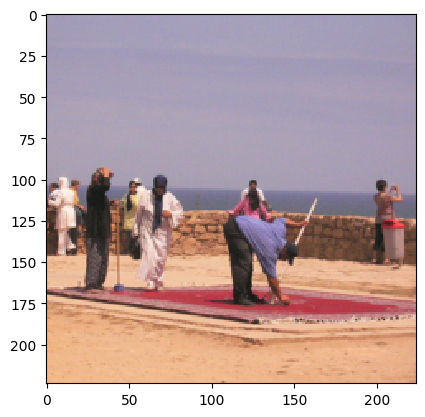

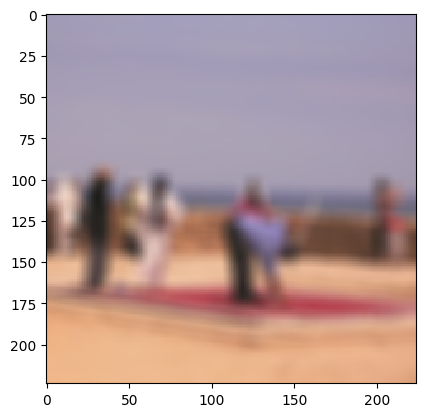

In [69]:
from PIL import ImageFilter, Image
#Hyper parameters. 
#TBD: Use argparse
tv_beta = 3
learning_rate = 0.1
max_iterations = 500
l1_coeff = 0.01
tv_coeff = 0.2
vv = 1483

img, labele = vall[vv]
model = load_model()
I = np.asarray(img)
img = np.float32(I) / 255
print(img.shape)
plt.imshow(I, interpolation='nearest')
plt.show()
blurred_img2 = cv2.GaussianBlur(img, (11, 11), 5)

#plt.imshow(blurred_img1, interpolation='nearest')
#plt.show()
#blurred_img2 = np.float32(cv2.medianBlur(I, 11))/255
plt.imshow(blurred_img2, interpolation='nearest')
plt.show()
#blurred_img_numpy = (blurred_img1 + blurred_img2) / 2
mask_init = np.ones((28, 28), dtype = np.float32)


In [68]:
# Convert to torch variables
img = preprocess_image(img)
print(img.shape)
blurred_img = preprocess_image(blurred_img2)
print(blurred_img.shape)
mask = numpy_to_torch(mask_init)
if use_cuda:
    upsample = torch.nn.UpsamplingBilinear2d(size=(224, 224)).cuda()
else:
    upsample = torch.nn.UpsamplingBilinear2d(size=(224, 224))
optimizer = torch.optim.Adam([mask], lr=learning_rate)

torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
